In [1]:
# loading the data
from pathlib import Path #for working with file system paths
import pandas as pd 
import tarfile #for reading and writing tar archives
import urllib.request #for fetching data from URLs

def load_housing_data():
    tar_path = Path("datasets/housing.tgz")
    if not tar_path.is_file() :
        Path("datasets").mkdir(parents=True, exist_ok=True) #creating the folder if not exist
        url= "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tar_path) #dowinloading dataset
        with tarfile.open(tar_path) as housing_tar:
            housing_tar.extractall(path="datasets") #extracting the tar file
    return pd.read_csv("datasets/housing/housing.csv")

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.dropna(subset=["total_bedrooms"], inplace=True)

In [5]:
housing_labels = housing["median_house_value"]

In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

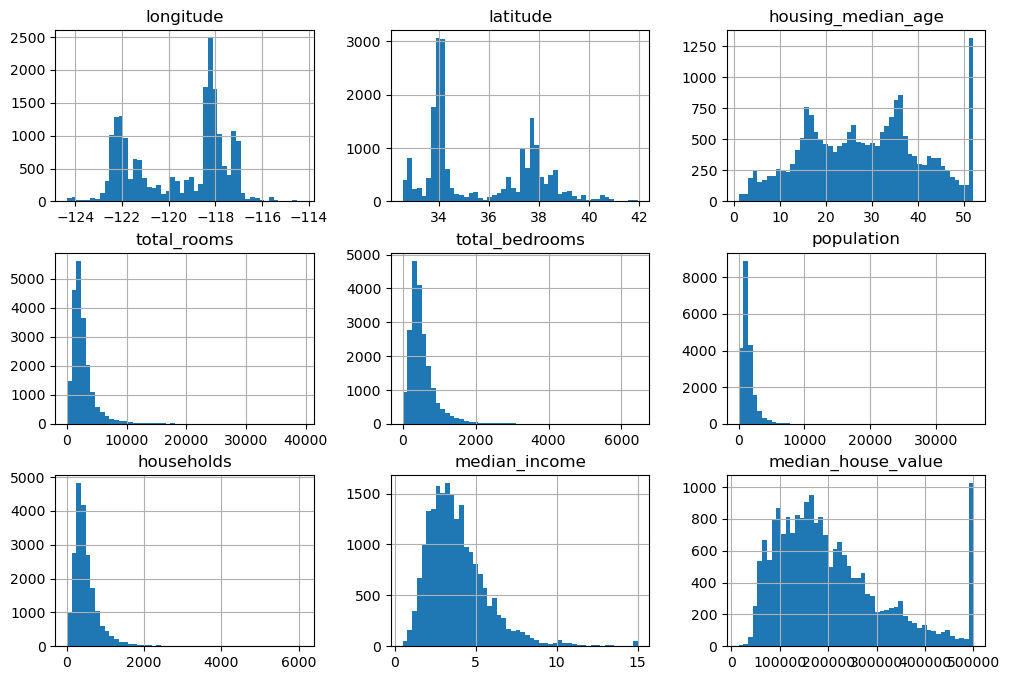

In [7]:
import matplotlib.pyplot as plt 

housing.hist(bins=50, figsize=(12, 8))
plt.show() 

In [8]:
import numpy as np

np.random.seed(42) #so it ganarates the same random indicies everytime

def shuffle_and_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train, test = shuffle_and_split(housing, 0.2)
len(train)

16347

In [9]:
#another way 
from sklearn.model_selection import train_test_split 
train, test = train_test_split(housing, test_size=0.2, random_state=42)

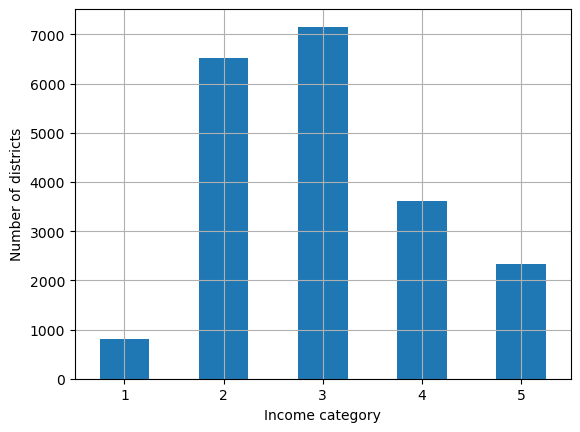

In [10]:
#applying startified sampling on the median income attribute
#assuming that it's very important for the prediction

housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0. , 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1,2,3,4,5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid= True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [11]:
train, test =train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])
print(train.shape)
print(test.shape)

(16346, 11)
(4087, 11)


In [12]:
for set_ in (train, test):
    set_.drop("income_cat", axis=1, inplace=True)

In [13]:
#housing = test.copy()
housing.shape

(20433, 11)

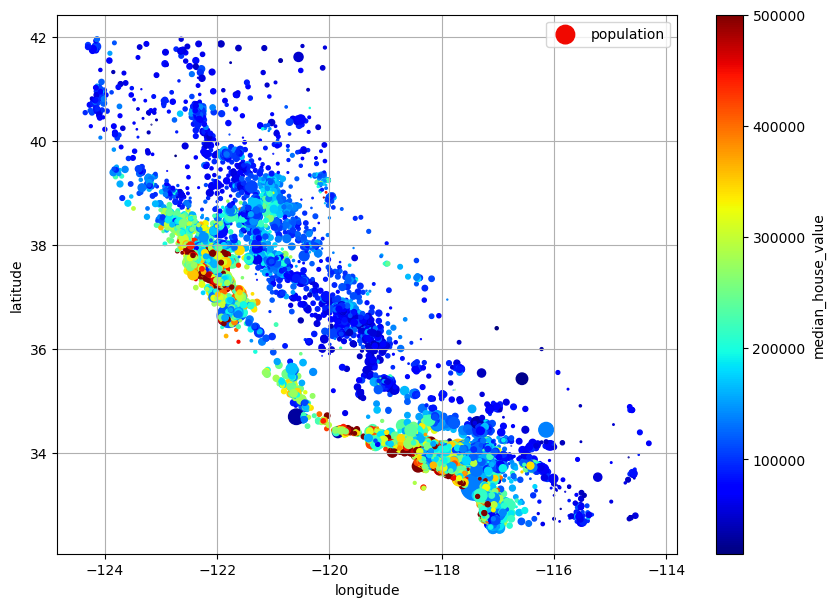

In [14]:
#ploting geographical information
#The radius of each circle represents the district’s population (option s),
#and the color represents the price (option c)
housing.plot(kind= "scatter", x= "longitude", y= "latitude", grid= True, 
             s= housing["population"]/100, label= "population",
             c= "median_house_value", cmap="jet", colorbar= True, legend= True,
             sharex= False, figsize= (10,7))
plt.show()

In [15]:
# Correlations
housing_numeric = housing.select_dtypes(include=[np.number])

corr_mtrx = housing_numeric.corr()
corr_mtrx["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688355
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
population           -0.025300
longitude            -0.045398
latitude             -0.144638
Name: median_house_value, dtype: float64

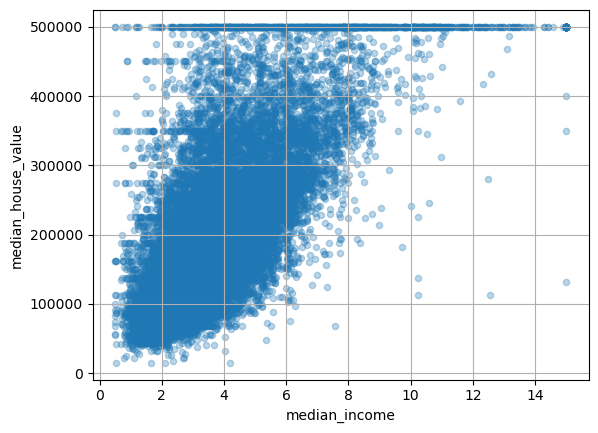

In [16]:
housing.plot(kind="scatter", x="median_income", 
    y="median_house_value", 
    alpha=0.3, grid=True)
plt.show()

In [17]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [18]:
housing_numeric = housing.select_dtypes(include=[np.number])

corr_mtrx = housing_numeric.corr()
corr_mtrx["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688355
rooms_per_house       0.151344
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
people_per_house     -0.023639
population           -0.025300
longitude            -0.045398
latitude             -0.144638
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

In [19]:
#data cleaning
#test.dropna(subset=["total_bedrooms"], inplace=True)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing.shape

(20433, 14)

In [20]:
housing_numeric = housing.select_dtypes(include=[np.number])

imputer.fit(housing_numeric)

SimpleImputer(strategy='median')

In [21]:
X = imputer.transform(housing_numeric)

In [22]:
#cause the transformer's output is a numpy array
housing_tr = pd.DataFrame(X, columns=housing_numeric.columns, index= housing_numeric.index)

In [23]:
housing_cat = housing[["ocean_proximity"]]

In [24]:
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder()
housing_cat_encoded = ord_encoder.fit_transform(housing_cat)

In [25]:
ord_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [26]:
#problrm: the ML algorithms will assume that two nearby values are more similar than two distant values.
from sklearn.preprocessing import OneHotEncoder

hot_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = hot_encoder.fit_transform(housing_cat)
housing_cat_1hot 

c:\Users\samam\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [27]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
housing_mmscaled = mmscaler.fit_transform(housing_numeric)

In [28]:
# Standrization
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
housing_sscaled = s_scaler.fit_transform(housing_numeric)

In [29]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [30]:
from sklearn.preprocessing import FunctionTransformer 
log_transformer = FunctionTransformer(np.log, 
inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [31]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None) -> None:
        self.n_clusters = n_clusters 
        self.gamma = gamma 
        self.random_state = random_state 

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X): # Computes RBF similarities between every data point in X and each cluster cente
        return rbf_kernel(X, self.kmeans_.cluster_centers_,gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

  
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],)


c:\Users\samam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [32]:
#the first three rows, rounding to two decimal places
similarities[:3].round(2)

array([[0.  , 0.24, 0.  , 0.  , 0.  , 0.  , 0.99, 0.01, 0.6 , 0.  ],
       [0.  , 0.24, 0.  , 0.  , 0.  , 0.  , 0.98, 0.01, 0.62, 0.  ],
       [0.  , 0.23, 0.  , 0.  , 0.  , 0.  , 0.98, 0.01, 0.62, 0.  ]])

In [33]:
from sklearn.pipeline import Pipeline

num_pipline = Pipeline([
    ("impute",SimpleImputer(strategy="mean"))
    ,("standrize", StandardScaler())
    ])

In [34]:
import sklearn

sklearn.set_config(display="diagram")

In [35]:
housing_num_prepared = num_pipline.fit_transform(housing_numeric)
housing_num_prepared[:2].round(2)

array([[-1.33,  1.05,  0.98, -0.8 , -0.97, -0.97, -0.98,  2.35,  2.13,
         0.63, -1.15, -0.05],
       [-1.32,  1.04, -0.61,  2.04,  1.35,  0.86,  1.67,  2.33,  1.31,
         0.32, -0.99, -0.09]])

In [36]:
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ["longitude", "latitude", "housing_median_age", 
"total_rooms", 
"total_bedrooms", "population", "households", 
"median_income"]
cat_attribs = ["ocean_proximity"] 

cat_pipeline = make_pipeline( 
                    SimpleImputer(strategy="most_frequent"), 
                    OneHotEncoder(handle_unknown="ignore")) 

from sklearn.compose import make_column_selector, make_column_transformer 
preprocessing = make_column_transformer( 
(num_pipline, make_column_selector(dtype_include=np.number)), 
(cat_pipeline, make_column_selector(dtype_include=object)),
 )

In [37]:
preprocessing.fit_transform(housing)

array([[-1.32731375,  1.05171726,  0.98216331, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32232256,  1.04235526, -0.60621017, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33230494,  1.03767426,  1.85576873, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.82320322,  1.77727236, -0.92388486, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87311515,  1.77727236, -0.84446619, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83318561,  1.74918635, -1.00330353, ...,  0.        ,
         0.        ,  0.        ]])

In [38]:
housing.head

<bound method NDFrame.head of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  ho

In [39]:
'''Missing values in numerical features will be imputed by replacing
 them with the median, as most ML algorithms don’t expect missing
 values. In categorical features, missing values will be replaced by the
 most frequent category.
 The categorical feature will be one-hot encoded, as most ML
 algorithms only accept numerical inputs.
 A few ratio features will be computed and added:
 bedrooms_ratio, rooms_per_house, and
 people_per_house. Hopefully these will better correlate with the
 median house value, and thereby help the ML models.
 A few cluster similarity features will also be added. These will likely
 be more useful to the model than latitude and longitude.
 Features with a long tail will be replaced by their logarithm, as most
 models prefer features with roughly uniform or Gaussian distributions.
 All numerical features will be standardized, as most ML algorithms
 prefer when all features have roughly the same scale.'''

'Missing values in numerical features will be imputed by replacing\n them with the median, as most ML algorithms don’t expect missing\n values. In categorical features, missing values will be replaced by the\n most frequent category.\n The categorical feature will be one-hot encoded, as most ML\n algorithms only accept numerical inputs.\n A few ratio features will be computed and added:\n bedrooms_ratio, rooms_per_house, and\n people_per_house. Hopefully these will better correlate with the\n median house value, and thereby help the ML models.\n A few cluster similarity features will also be added. These will likely\n be more useful to the model than latitude and longitude.\n Features with a long tail will be replaced by their logarithm, as most\n models prefer features with roughly uniform or Gaussian distributions.\n All numerical features will be standardized, as most ML algorithms\n prefer when all features have roughly the same scale.'

In [40]:
#housing_labels = housing["median_house_value"]
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(housing_prepared_df, housing_labels, test_size=0.2, random_state=42)
# Split the data before fitting preprocessing
X_train_raw, X_test_raw, y_train, y_test = train_test_split(housing, housing_labels, test_size=0.2, random_state=42)
preprocessing.fit(X_train_raw)  # Fit only on training data
X_train = preprocessing.transform(X_train_raw)
X_test = preprocessing.transform(X_test_raw)

# Initialize the model
model = LinearRegression()

# Fit the model to the prepared data
model.fit(X_train, y_train)

simple_model = LinearRegression()
simple_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
X_train_simple = simple_pipeline.fit_transform(X_train_raw[["median_income"]])
X_test_simple = simple_pipeline.transform(X_test_raw[["median_income"]])
simple_model.fit(X_train_simple, y_train)
print("Training score (simple):", simple_model.score(X_train_simple, y_train))
print("Test score (simple):", simple_model.score(X_test_simple, y_test))


# Evaluate the model
print("Training score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))

Training score (simple): 0.4724396476657583
Test score (simple): 0.4792251873362303
Training score: 1.0
Test score: 1.0


In [41]:
import pandas as pd
correlations = pd.DataFrame(housing_numeric).corrwith(housing_labels)
print(correlations)


longitude            -0.045398
latitude             -0.144638
housing_median_age    0.106432
total_rooms           0.133294
total_bedrooms        0.049686
population           -0.025300
households            0.064894
median_income         0.688355
median_house_value    1.000000
rooms_per_house       0.151344
bedrooms_ratio       -0.255880
people_per_house     -0.023639
dtype: float64


In [42]:
import numpy as np
common_rows = np.intersect1d(X_train_raw.index, X_test_raw.index)
print("Common rows between training and test sets:", common_rows)

Common rows between training and test sets: []


In [43]:
print("Sample of total_bedrooms, total_rooms:")
print(X_train_raw[["total_bedrooms", "total_rooms"]].head())

print("Output of column_ratio:")
print(X_train[:5, :])  # Verify the specific columns created by ratio pipelines

Sample of total_bedrooms, total_rooms:
       total_bedrooms  total_rooms
17743           540.0       2777.0
2060            611.0       2289.0
6443            566.0       2650.0
4616            266.0       1025.0
15277           369.0       1402.0
Output of column_ratio:
[[ 0.80427618 -0.76489159  0.4277486   0.0603562   0.00201545  0.46133808
   0.05443953  0.34250306 -0.19774356 -0.04181638 -0.32179099  0.05529334
   1.          0.          0.          0.          0.        ]
 [-1.61117689  1.35341826 -1.31689556 -0.1599175   0.16846096 -0.44317134
   0.10089951 -1.43357312 -0.58402711 -0.51261932  0.93469858 -0.1198252
   1.          0.          0.          0.          0.        ]
 [-1.33227922  0.99414544  1.85518474  0.00303087  0.06296733  0.03661192
   0.17058947 -0.45025787  0.07916532 -0.32324479  0.00987427 -0.0437185
   0.          0.          0.          1.          0.        ]
 [ 0.79431555 -0.83021392 -0.28596946 -0.73046251 -0.64032358 -0.61183831
  -0.82055668  0.00361

In [44]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0


In [45]:
import numpy as np
noise = np.random.normal(0, 0.1, size=X_train.shape)
X_train_noisy = X_train + noise
model.fit(X_train_noisy, y_train)
print("Training score with noise:", model.score(X_train_noisy, y_train))
print("Test score with noise:", model.score(X_test, y_test))


Training score with noise: 0.9902642938646499
Test score with noise: 0.9997392936432038


In [46]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

print("Training score:", model.score(X_train, y_train))
print("Test score:", model.score(X_test, y_test))


Training score: 0.9999999892221485
Test score: 0.9999999893479335


In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f"Mean cross-validation score: {scores.mean()}")


Mean cross-validation score: 0.9999999829226625


In [48]:
from sklearn.compose import ColumnTransformer
def column_ratio(x):
    return x[:, [0]] / x[:, [1]]

#If FunctionTransformer is used without it the pipeline won't automatically know how to name the resulting features
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
       SimpleImputer(strategy="median"), 
        FunctionTransformer(column_ratio, 
        feature_names_out=ratio_name), 
        StandardScaler())
log_pipeline = make_pipeline( 
SimpleImputer(strategy="median"), 
FunctionTransformer(np.log, feature_names_out="one-to-one"), 
StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
preprocessing = ColumnTransformer([ 
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]), 
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]), 
    ("people_per_house", ratio_pipeline(), ["population", "households"]), 
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]), 
    ("geo", cluster_simil, ["latitude", "longitude"]), 
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)), 
], 
remainder=default_num_pipeline) 

housing_prepared = preprocessing.fit_transform(housing)
preprocessing.get_feature_names_out()

c:\Users\samam\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age', 'remainder__median_house_value',
       'remainder__income_cat', 'remainder__rooms_per_house',
       'remainder__bedrooms_ratio', 'remainder__people_per_house'],
      dtype=object)